In [2]:
import math
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
# from scipy.fftack import fft, fft2, fftshift

In [3]:
def plot(data, title, color="blue", axes=None):
    if axes is None:
        plt.gca()
    else:
        plt.axes(axes)
    
    plt.plot(data , '-', color=color, label=title)
    plt.title(title)
    plt.legend()


# data = np.random.randn(1000)
# fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 5))
# plot(data, title="::title::", color="red", axes=axs[0])
# plot(data, title="::title::", color="blue", axes=axs[1])
# plt.show()

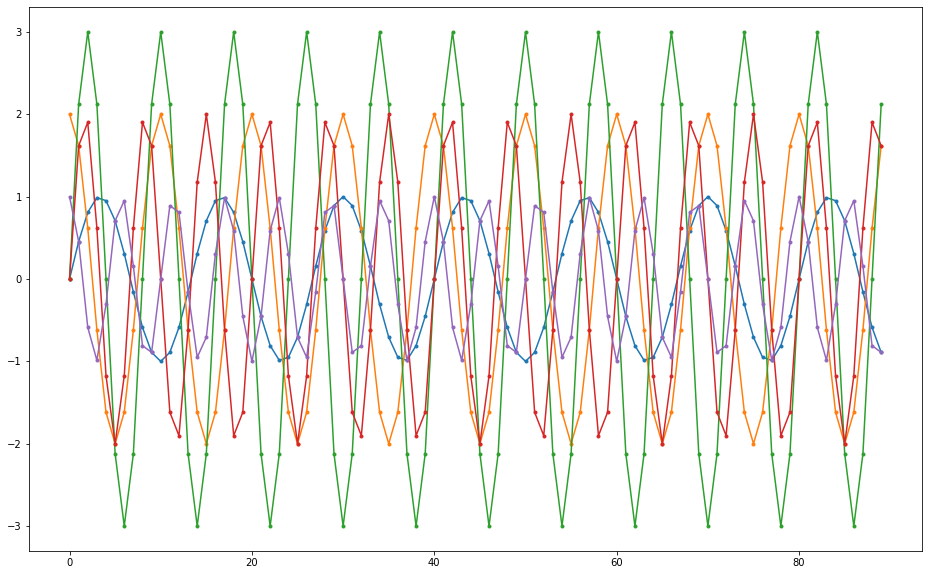

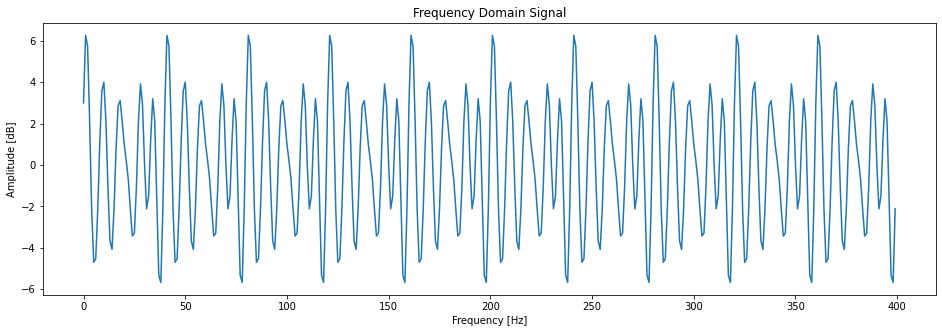

In [4]:
# Consider a fourier series with sum of sine waves: A sin(2 π f t + ϕ)
# wher A is domain amplitude, f is frequency, ϕ is phase, and t is time.
# A   | f (HZ) | ϕ (DEG) | t (SEC)
# ----|--------|----
# 1   | 30     | 0
# 2   | 40     | pi/2
# 3   | 50     | 0
# 2   | 60     | 0
# 1   | 70     | pi/2

# x(t) = A sin(2πft + φ) time domain.
# A in the Amplitude parameter. (A is the signal magnitude, and ϕ corresponds to signal phase)
# ϕ in radians in the Phase offset parameter.
# f in hertz in the Frequency parameter.
# x(t) = A exp(j(2πft + ϕ)) = A {cos(2πft + ϕ) + j sin(2πft + ϕ)}


A = np.array([1, 2, 3, 2, 1])
f = np.array([30, 40, 50, 60, 70])
phi = np.array([0, np.pi/2, 0, 0, np.pi/2])

sampling_freq = 400        # sampling frequency - samples per second)
delta_t = 1/sampling_freq  # sampling period
freq_domain_signal = np.zeros(int(1/delta_t))
plt.figure(figsize=(16, 10))
for i in range(len(A)):
    sine_waves = A[i]*np.sin(2*np.pi*f[i]*np.arange(0, 1, delta_t) + phi[i])
    plt.plot(sine_waves[:90], marker='.', label='f = ' + str(f[i]) + ' Hz')
    freq_domain_signal += A[i] * np.sin(2 * np.pi * f[i] * delta_t * np.arange(len(freq_domain_signal)) + phi[i])
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(freq_domain_signal)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('Frequency Domain Signal')
plt.show()

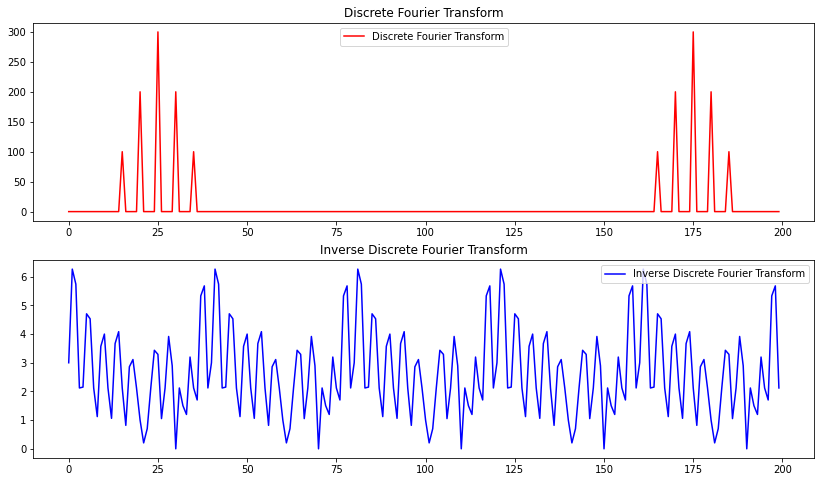

In [5]:
dft = np.fft.fft(freq_domain_signal, n=200)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
plot(np.abs(dft), title="Discrete Fourier Transform", color="red", axes=axs[0])
plot(np.abs(np.fft.ifft(dft)), title="Inverse Discrete Fourier Transform", color="blue", axes=axs[1])
plt.show()

C:\ProgramData\Anaconda3\envs\RT-Academy\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


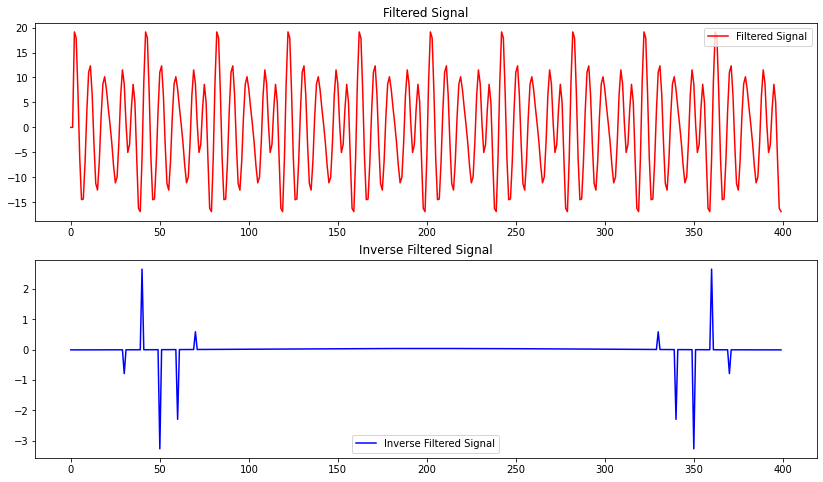

In [7]:
def notch_filter(signal, sampling_freq, cutoff_freq):
    w_cutoff = 2 * np.pi * cutoff_freq / sampling_freq
    w_cutoff_rad2deg = np.rad2deg(w_cutoff)
    y_n = np.zeros(len(signal))
    for i in range(2, len(signal)):
        y_n[i] = signal[i] - (2 * np.cos(w_cutoff_rad2deg) * signal[i - 1]) + signal[i - 2]
    return y_n

filtered_signal_ = notch_filter(freq_domain_signal, sampling_freq, 60)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
plot(filtered_signal_, title="Filtered Signal", color="red", axes=axs[0])
plot(np.fft.ifft(filtered_signal_), title="Inverse Filtered Signal", color="blue", axes=axs[1])
plt.show()


C:\ProgramData\Anaconda3\envs\RT-Academy\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


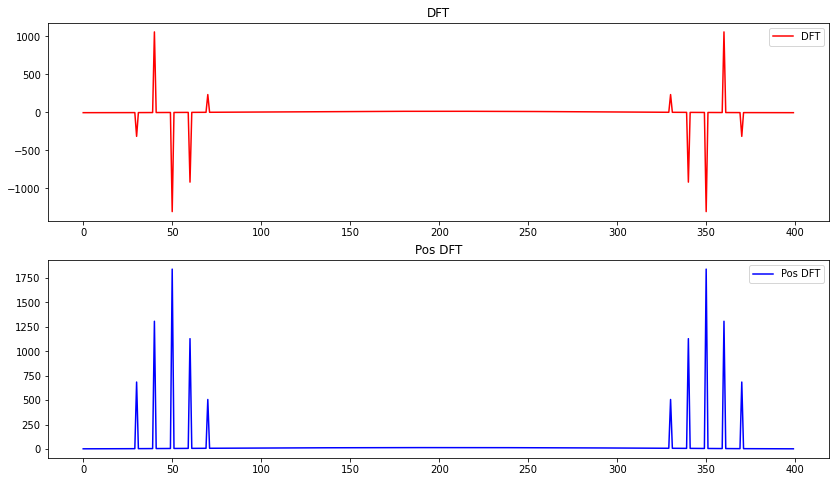

In [8]:
discrete_fourier_trans = np.fft.fft(filtered_signal_)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
plot(discrete_fourier_trans, color="red", title="DFT", axes=axs[0])
plot(np.abs(discrete_fourier_trans), color="blue", title="Pos DFT", axes=axs[1])
plt.show()

<ipython-input-14-9d6717f2b0ed>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  X_z[i] = freq_domain_signal[i] * (z_1 ** (-i))
C:\ProgramData\Anaconda3\envs\RT-Academy\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


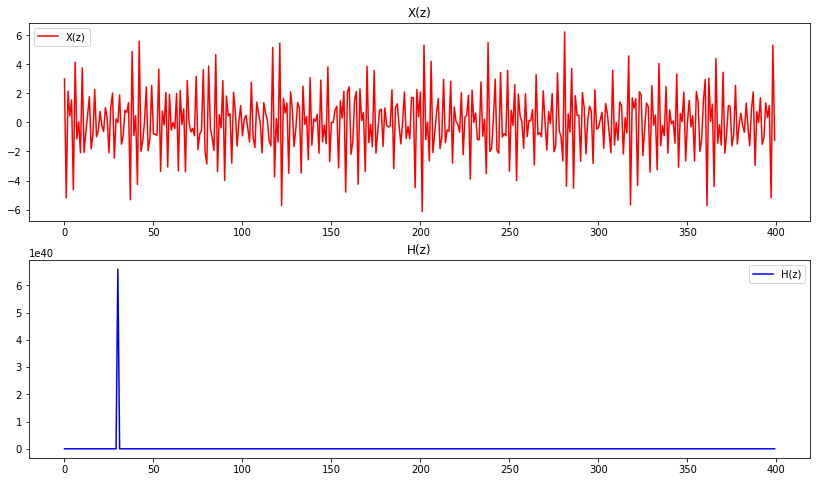

In [14]:
cutoff_freq = 60
sampling_freq = 400
# w_cutoff = np.rad2deg(2 * np.pi * cutoff_freq / sampling_freq)
# z_1 = np.cos(w_cutoff) + 1j * np.sin(w_cutoff)
# z_2 = np.cos(w_cutoff) - 1j * np.sin(w_cutoff)

w_cutoff = 2 * np.pi * cutoff_freq / sampling_freq
z_1 = math.cos(w_cutoff) + 1j * math.sin(w_cutoff)
z_2 = math.cos(w_cutoff) - 1j * math.sin(w_cutoff)

X_z = np.zeros(len(freq_domain_signal))
for i in range(len(freq_domain_signal)):
    X_z[i] = freq_domain_signal[i] * (z_1 ** (-i))


def notch_filter_z_transform(x_z, z_1, z_2):
    h_z = np.zeros(len(x_z), dtype=complex)
    for i in range(len(x_z)):
        h_z[i] = (1 - (x_z[i] ** (-1)) * z_1) * (1 - (x_z[i] ** (-1)) * z_2)
    return h_z


h_z = notch_filter_z_transform(X_z, sampling_freq, cutoff_freq)
# print("H(z) = ", h_z)


fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 8))
plot(X_z, title="X(z)", color="red", axes=axs[0])
plot(notch_filter_z_transform(X_z, sampling_freq, cutoff_freq),
     title="H(z)", color="blue", axes=axs[1])
plt.show()


In [11]:
"""Omega  54.0
z1, z2 (-0.8293098328631502-0.5587890488516163j) (-0.8293098328631502+0.5587890488516163j)
H(1) [3.65861967+0.j]
"""

'Omega  54.0\nz1, z2 (-0.8293098328631502-0.5587890488516163j) (-0.8293098328631502+0.5587890488516163j)\nH(1) [3.65861967+0.j]\n'

## Test with library

notch filter coefficients:numerator: [ 0.98453371 -1.15738879  0.98453371]denominator: [ 1.         -1.15738879  0.96906742]


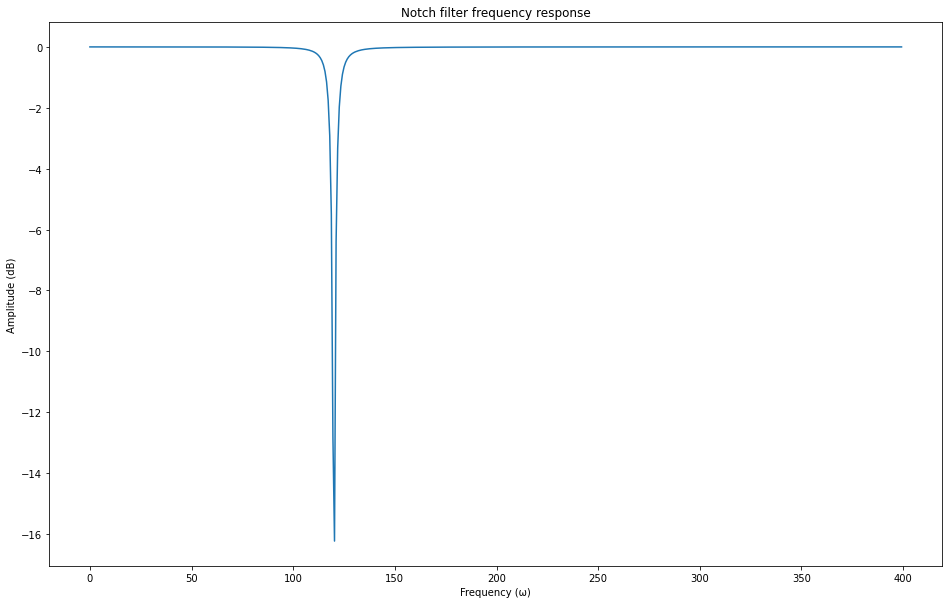

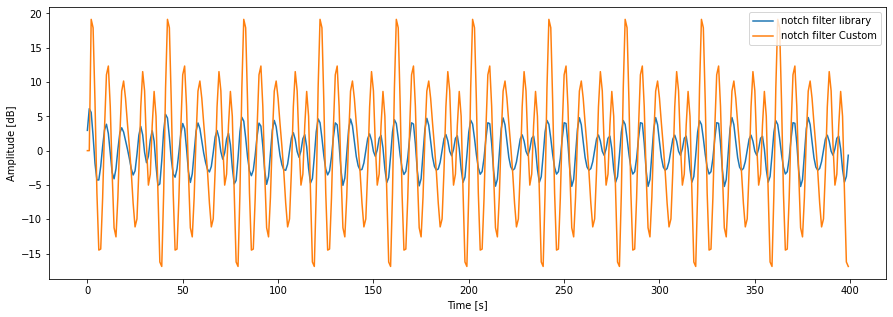

In [ ]:
def notch_filter(f_sampling, f_cutoff):
    """
    Notch filter
    consider DC gain of 1
    """
    nyquist_rate = f_sampling / 2
    normal_cutoff = f_cutoff / nyquist_rate
    b, a = sp.iirnotch(w0=normal_cutoff, Q=30)
    return b, a    

f_sampling = 400 # Hz (sampling frequency)
f_cutoff = 60 # Hz (cutoff frequency)
b, a = notch_filter(f_sampling, f_cutoff)

print('notch filter coefficients:' + "numerator: " + str(b) + "denominator: " + str(a))

# plot notch filter
# Magnitude Response, Bandwidth=0.2 radian/sample
w, h = sp.freqz(b, a) # w is frequency in radians 
plt.figure(figsize=(16, 10))
plt.plot((w/np.pi)*f_sampling, 20*np.log10(np.abs(h)))
plt.xlabel('Frequency (ω)')
plt.ylabel('Amplitude (dB)')
plt.title('Notch filter frequency response')
plt.show()

filtered_signal = sp.lfilter(b, a, freq_domain_signal)

plt.figure(figsize=(15, 5))
plt.plot(filtered_signal, label='notch filter library')
plt.plot(filtered_signal_, label='notch filter Custom')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [dB]')
plt.legend()
plt.show()